In [109]:
import h5py
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import pickle

In [110]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [111]:
file_predictions = 'predictions.txt'
train_file = 'MA0035_4_m5_train.h5'
test_file = 'MA0035_4_m5_test.h5'

In [112]:
h5_train = h5py.File(train_file, 'r')
h5_test = h5py.File(test_file, 'r')

In [113]:
train_data = h5_train['data']
train_binlabels = h5_train['binlabels']

print(train_data.shape)

val_data = train_data[-10000:]
val_binlabels = train_binlabels[-10000:] #Can be hyperparam

train_data = train_data[:90000]
train_binlabels = train_binlabels[:90000]

(100000, 4, 1000)


In [114]:
hyperparameters = {
    'l0_dropout_rate': [0.5],
    'l1_hidden_units': [8, 16, 32, 64, 128, 254, 512],
    'l1_dropout_rate': [0.5, 0.6, 0.7],
    'epochs': [100, 200, 300, 500, 1000], #More epochs
    'batch_size': [1, 32, 64, 128, 256, 512] #Try on gpu with bigger batch size 128, 256, 512
}
iteration = 0
my_callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=2),
    # tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir=('./logs/log' + str(iteration))),
]

#make a loop with different hyperparameters for overnight



model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(4, 1000)),
        tf.keras.layers.Dropout(hyperparameters['l0_dropout_rate'][0]),
        tf.keras.layers.Dense(hyperparameters['l1_hidden_units'][2], activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(hyperparameters['l1_dropout_rate'][0]),
        tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
    ]
)
with tf.device('/GPU:0'):
    model.compile(
        optimizer = tf.optimizers.Adam(),
        loss = 'binary_crossentropy',
        metrics=[tf.keras.metrics.AUC()]
    )

    history = model.fit(train_data, train_binlabels,
            epochs=hyperparameters['epochs'][0], 
            validation_data=(val_data, val_binlabels),
            batch_size=hyperparameters['batch_size'][3],
            callbacks=my_callbacks)

Epoch 1/100
704/704 [==============================] - 2s 2ms/step - loss: 0.6444 - auc_12: 0.5001 - val_loss: 0.6188 - val_auc_12: 0.4995
Epoch 2/100
704/704 [==============================] - 1s 2ms/step - loss: 0.6235 - auc_12: 0.5057 - val_loss: 0.6181 - val_auc_12: 0.5025
Epoch 3/100
704/704 [==============================] - 1s 2ms/step - loss: 0.6185 - auc_12: 0.5225 - val_loss: 0.6179 - val_auc_12: 0.5128
Epoch 4/100
704/704 [==============================] - 1s 2ms/step - loss: 0.6165 - auc_12: 0.5338 - val_loss: 0.6181 - val_auc_12: 0.5114
Epoch 5/100
704/704 [==============================] - 1s 2ms/step - loss: 0.6165 - auc_12: 0.5367 - val_loss: 0.6179 - val_auc_12: 0.5087
Epoch 6/100
704/704 [==============================] - 1s 2ms/step - loss: 0.6138 - auc_12: 0.5400 - val_loss: 0.6182 - val_auc_12: 0.5128
Epoch 7/100
704/704 [==============================] - 1s 2ms/step - loss: 0.6160 - auc_12: 0.5462 - val_loss: 0.6180 - val_auc_12: 0.5098
Epoch 8/100
704/704 [======

In [115]:
test_data = h5_test['data'][:]
test_binlabels = h5_test['binlabels'][:]

In [116]:
acc, auc = model.evaluate(test_data, test_binlabels)

313/313 [==============================] - 0s 1ms/step - loss: 0.5810 - auc_12: 0.5059


In [117]:
yhat = model.predict(test_data)

In [118]:
fpr, tpr, _ = roc_curve(test_binlabels, yhat)

In [119]:
roc_auc = roc_auc_score(test_binlabels, yhat)

In [120]:
import os
try:
    os.makedirs('pickle')
except OSError as e:
    pass

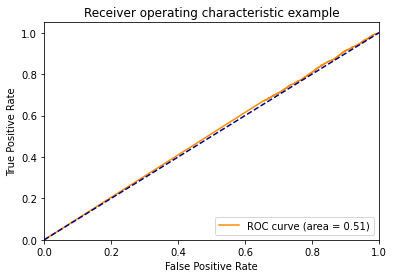

In [121]:
roc = plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# ax.axis(xmin=0.0, xmax=1.0, ymin=0.0, ymax=1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('roc.pdf')
pickle.dump(roc, open('pickle/roc.fig.pickle', 'wb'))
plt.show()

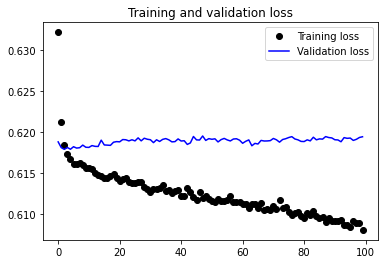

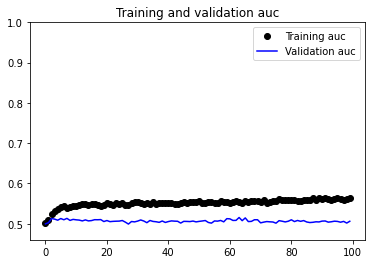

In [123]:
loss = plt.figure(1) #Loss
history_loss = history.history['loss']
history_val_loss = history.history['val_loss']
epochs = range(len(history_loss))
plt.plot(epochs, history_loss, 'ko', label='Training loss')
plt.plot(epochs, history_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.pdf')
pickle.dump(loss, open('pickle/loss.fig.pickle', 'wb'))

auc = plt.figure(2) #AUC
history_auc = history.history['auc_12']
history_val_auc = history.history['val_auc_12']
epochs = range(len(history_auc))
plt.plot(epochs, history_auc, 'ko', label='Training auc')
plt.plot(epochs, history_val_auc, 'b', label='Validation auc')
plt.title('Training and validation auc')
plt.ylim(0.46, 1.0)
plt.legend()
plt.savefig('auc.pdf')
pickle.dump(auc, open('pickle/auc.fig.pickle', 'wb'))

plt.show()